In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score, precision_score,classification_report, confusion_matrix, roc_curve, roc_auc_score,auc
from pandas import set_option
import seaborn as sns

In [2]:
set_option('display.max_row', 10)
set_option('display.width', 100)
set_option('precision', 2)
set_option('display.max_column', 40)

In [3]:
df= pd.read_csv('CC.csv') 
df_korban_fraud = df_korban[df_korban.LABEL==1].copy()
df_non_korban = pd.read_csv('datanonfraud.csv')
frames= [df_korban_fraud, df_non_korban.sample(8821)] # SAMPEL TERDIRI DARI 10000 BARIS YANG DIAMBIL SECARA ACAK
data= pd.concat(frames)
y_true = data['LABEL']


C:\Users\leno\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.shape # DIMENSI DATA ( BARIS, KOLOM/ JUMLAH FITUR SEBELUM DILAKUKAN ONE HOT ENCODING)

(10000, 19)

TAHAP 3.1 : PREPROCESSING DATA

In [5]:
data.duplicated().sum() # JUMLAH BARIS DATA YANG TERDUPLIKASI

9

In [6]:
data.loc[data.duplicated(keep = False), :] # TAMPILKAN DATA YANG TERDUPLIKASI

,LABEL,fiturid,responcode,avlblnc,txamount,transtime,terminaltype,jenis_kartu,groupname,dana_keluar,lokasi,responcode_before,seq.trxday,CekSaldo.before,diff.time,diff.txamount,diff.txamount.trx,diff.txamount.bef,percent_saldo
79181,0,201010170,0,6.02e+06,0,50691,INTERNET BANKING,BRITAMA,CekSaldo,False,dalam,0,0,1,59,0.00,0.00,0.0,0.00
17235,0,201010170,0,4.90e+06,0,36246,ATM_BRI,BRITAMA,CekSaldo,False,dalam,0,0,1,0,0.00,0.00,0.0,0.00
48909,0,201010170,0,7.59e+05,0,55141,ATM_BRI,BRITAMA,CekSaldo,False,dalam,0,0,1,76,0.00,0.00,0.0,0.00
269741,0,201010170,0,1.52e+05,0,71505,ATM MERAH PUTIH,BRITAMA,CekSaldo,False,dalam,0,0,1,0,0.00,0.00,0.0,0.00
71191,0,201010170,0,6.06e+04,0,35504,INTERNET BANKING,SIMPEDES,CekSaldo,False,dalam,0,0,1,147,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15117,0,201010170,0,5.23e+04,0,44628,ATM_BRI,SIMPEDES,CekSaldo,False,dalam,0,0,1,0,0.00,0.00,0.0,0.00
237898,0,201010170,0,8.81e+06,0,60533,INTERNET BANKING,BRITAMA,CekSaldo,False,dalam,0,0,1,67,0.00,0.00,0.0,0.00
72236,0,201010170,0,6.06e+04,0,35504,INTERNET BANKING,SIMPEDES,CekSaldo,False,dalam,0,0,1,147,0.00,0.00,0.0,0.00
89808,0,103010020,0,2.63e+06,2000000,34740,ATM_BRI,BRITAMA,TarikTunai,True,dalam,0,2,1,75,0.33,0.33,0.0,0.86


In [7]:
data= data.drop_duplicates(keep= 'first')


In [8]:
data.responcode =pd.to_numeric(data.responcode, errors='coerce').fillna(-1, downcast='infer') # TERDAPAT NAN YANG HARUS DIHILANGKAN
data.responcode_before =pd.to_numeric(data.responcode_before, errors='coerce').fillna(-1, downcast='infer')

In [9]:
data[data['LABEL']==1].describe()   # DESKRIPSI DATA DENGAN LABEL = 1 ATAU TRANSAKSI FRAUD

,LABEL,fiturid,responcode,avlblnc,txamount,transtime,responcode_before,seq.trxday,CekSaldo.before,diff.time,diff.txamount,diff.txamount.trx,diff.txamount.bef,percent_saldo
count,1179.0,1.18e+03,1179.00,1.18e+03,1.18e+03,1179.00,1179.0,1179.00,1179.00,1179.00,1.18e+03,1.18e+03,1.18e+03,1.18e+03
mean,1.0,1.13e+08,14.80,2.23e+07,2.44e+06,42452.84,12.0,3.21,0.49,64.25,3.45e+04,7.54e+05,3.45e+04,4.84e+01
std,0.0,3.04e+07,25.06,1.89e+08,9.12e+06,20143.72,23.2,3.27,0.50,626.61,6.83e+05,1.56e+07,6.83e+05,1.49e+03
min,1.0,1.03e+08,0.00,0.00e+00,1.00e+03,8.00,0.0,1.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,4.08e-05
25%,1.0,1.03e+08,0.00,0.00e+00,4.00e+05,27799.00,0.0,1.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,9.62e-02
50%,1.0,1.03e+08,0.00,7.23e+05,1.25e+06,41328.00,0.0,2.00,0.00,25.00,6.13e-01,9.09e-01,3.33e-01,3.84e-01
75%,1.0,1.03e+08,51.00,6.56e+06,2.00e+06,59873.00,0.0,4.00,1.00,34.00,2.04e+00,2.53e+00,9.50e-01,9.04e-01
max,1.0,2.06e+08,93.00,2.87e+09,2.65e+08,85168.00,61.0,32.00,1.00,16804.00,1.50e+07,5.23e+08,1.50e+07,5.10e+04


In [10]:
data= data.dropna() # DROP MISSING VALUE PADA KESELURUHAN DATA


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 3853 to 180004
Data columns (total 19 columns):
LABEL                9990 non-null int64
fiturid              9990 non-null int64
responcode           9990 non-null int64
avlblnc              9990 non-null float64
txamount             9990 non-null int64
transtime            9990 non-null int64
terminaltype         9990 non-null object
jenis_kartu          9990 non-null object
groupname            9990 non-null object
dana_keluar          9990 non-null bool
lokasi               9990 non-null object
responcode_before    9990 non-null int64
seq.trxday           9990 non-null int64
CekSaldo.before      9990 non-null int64
diff.time            9990 non-null int64
diff.txamount        9990 non-null float64
diff.txamount.trx    9990 non-null float64
diff.txamount.bef    9990 non-null float64
percent_saldo        9990 non-null float64
dtypes: bool(1), float64(5), int64(9), object(4)
memory usage: 1.5+ MB


TAHAP 3.2: ONE HOT ENCODING PADA FITUR CATEGORIAL

In [12]:
one_hot = pd.get_dummies(data['responcode']) # RESPONCODE MEMILIKI TYPE OBJECT SEHINGGA HARUS DILAKUKAN ONE HOT ENCODING 
data= data.drop('responcode', axis =1)
data= pd.concat([data, one_hot], axis=1)


In [13]:
one_hot = pd.get_dummies(data['responcode_before'])# RESPONCODE_BEFORE MEMILIKI TYPE OBJECT SEHINGGA HARUS DILAKUKAN ONE HOT ENCODING 
data= data.drop('responcode_before', axis =1)
data= pd.concat([data, one_hot], axis=1)


In [14]:
one_hot = pd.get_dummies(data['terminaltype'])
data= data.drop('terminaltype', axis =1)
data= pd.concat([data, one_hot], axis=1)


In [15]:
one_hot = pd.get_dummies(data['jenis_kartu'])
data= data.drop('jenis_kartu', axis =1)
data= pd.concat([data, one_hot], axis=1)


In [16]:
one_hot = pd.get_dummies(data['groupname'])
data= data.drop('groupname', axis =1)
data= pd.concat([data, one_hot], axis=1)


In [17]:
one_hot = pd.get_dummies(data['dana_keluar'])
data= data.drop('dana_keluar', axis =1)
data= pd.concat([data, one_hot], axis=1)


In [18]:
one_hot = pd.get_dummies(data['lokasi'])
data= data.drop('lokasi', axis =1)
data= pd.concat([data, one_hot], axis=1)


LANGKAH 3.3 : MEMBAGI DATA MENJADI FITUR DAN LABEL

In [19]:
# FITUR ID SUDAH DIWALIKI OLEH GROUPNAME
data.drop(['fiturid'], axis=1, inplace=True) 


In [20]:
data.head() # fiturid sudah dibuang

,LABEL,avlblnc,txamount,transtime,seq.trxday,CekSaldo.before,diff.time,diff.txamount,diff.txamount.trx,diff.txamount.bef,percent_saldo,-1,0,3,5,30,51,61,92,93,...,Bersama,CDM,EDC,Himbara,INTERNET BANKING,Maestro,Prima,SMS BANKING,BRITAMA,PRIORITAS,SIMPEDES,CekSaldo,TarikTunai,TransferBRI,TransferBRIVA,TransferBersama,False,True,dalam,luar
3853,1,1.15e+06,100000,28893,1,1,0,0.0,0.0,0.86,0.08,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0
8023,1,0.00e+00,200000,4099,1,0,0,0.0,0.0,0.60,3.83,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0
8024,1,5.23e+04,150000,4123,2,0,24,0.0,0.0,0.25,6.70,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0
9960,1,5.00e+05,1000000,48153,1,0,0,0.0,0.0,0.33,2.00,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0
10485,1,4.59e+07,1000000,69395,1,0,0,0.0,0.0,0.60,0.02,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0


In [21]:
X = data.iloc[:, data.columns != "LABEL"]
Y = data.iloc[:, data.columns == "LABEL"]

LANGKAH 3.4: MEMBAGI DATA MENJADI DUA DATASET TERPISAH YAKNI DATASET TRAIN DAN TESTING

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.37, random_state= None) # UKURAN DATA TESTING YAKNI 2000 BARIS

LANGKAH 3: PEMODELAN DENGAN DECISION TREE CLASSIFIER. ALGORITMA INI TIDAK MEMBUTUHKAN TAHAPAN FEATURE SCALING ( SEBASTIAN RASCHKA)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      3249
          1       0.92      0.95      0.93       448

avg / total       0.98      0.98      0.98      3697

AKURASI PADA DATA TRAINING: 0.9985698395042111
AKURASI PADA DATA TESTING: 0.9835001352447931


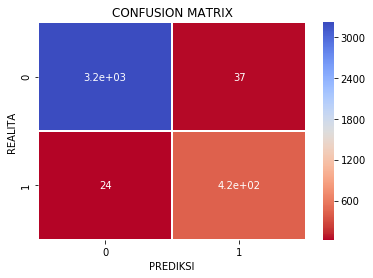

WAKTU EKSEKUSI PROGRAM (dalam detik) yakni: 0.3978245258331299


In [39]:
# RUNNING DTC WITH BEST PARAMETERS
import time
start = time.time()
clf= DecisionTreeClassifier(criterion='entropy', splitter='best',
                            max_depth=11, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features=None, random_state=None, max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))
print('AKURASI PADA DATA TRAINING:',clf.score(X_train, y_train))
print('AKURASI PADA DATA TESTING:', clf.score(X_test, y_test))


matrix = confusion_matrix(y_test, pred)
sns.heatmap(matrix, cmap="coolwarm_r", annot=True, linewidths=0.5)
pyplot.title("CONFUSION MATRIX")
pyplot.xlabel("PREDIKSI")
pyplot.ylabel("REALITA")
pyplot.show()
end = time.time()
print("WAKTU EKSEKUSI PROGRAM (dalam detik) yakni:",end - start)



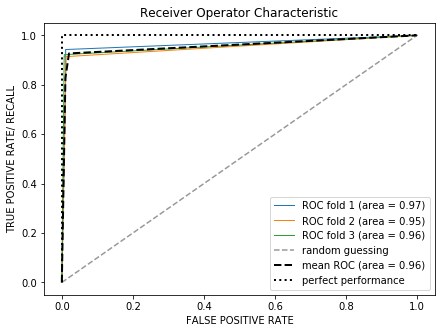

In [40]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.cross_validation import StratifiedKFold
import numpy as np
X_train2 = X_train.values

cv = StratifiedKFold(y_train.values.reshape(-1,), n_folds=3 ,random_state=1)
fig = pyplot.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = clf.fit(X_train2[train],
    y_train.values.reshape(-1,)[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train.values.reshape(-1,)[test], probas[:, 1],
    pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    pyplot.plot(fpr,tpr,lw=1,label='ROC fold %d (area = %0.2f)'% (i+1, roc_auc))
pyplot.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
pyplot.plot(mean_fpr, mean_tpr, 'k--',
label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
pyplot.plot([0, 0, 1],[0, 1, 1],lw=2,linestyle=':',color='black',
label='perfect performance')
pyplot.xlim([-0.05, 1.05])
pyplot.ylim([-0.05, 1.05])
pyplot.xlabel('FALSE POSITIVE RATE')
pyplot.ylabel('TRUE POSITIVE RATE/ RECALL')
pyplot.title('Receiver Operator Characteristic')
pyplot.legend(loc="lower right")
pyplot.show()                         
                                     